In [17]:
!unzip /content/drive/MyDrive/fashion-mnist.zip

Archive:  /content/drive/MyDrive/fashion-mnist.zip
replace fashion-mnist/valid/3/8083.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [48]:

#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./fashion-mnist/train/*/*.png')
valid_files = glob('./fashion-mnist/valid/*/*.png')
test_files = glob('./fashion-mnist/test/*/*.png')

train_files[0]

'./fashion-mnist/train/8/45081.png'

In [49]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)


(55000, 10000, 5000)

In [50]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [51]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [34]:

#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

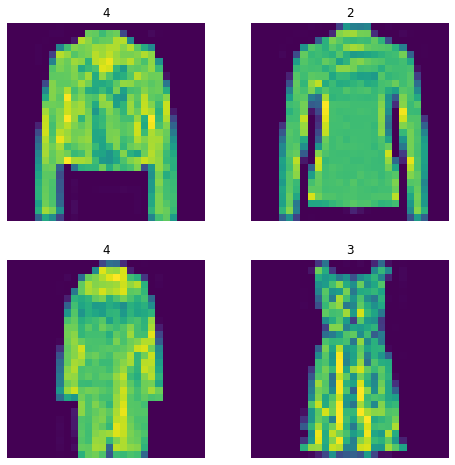

In [35]:
#-- Visualizamos los datos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [36]:
#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable


X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([55000, 28, 28])

In [37]:

import torch

batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [38]:
#-- Después de activar el entorno GPU se selecciona el dispositivo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:

model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 20, kernel_size=6, stride=1, padding=1),
  # ( (28-6+1*2)/1 ) + 1 = 25   -> 25*25*20

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=3),
  # 25/3 = 8                 -> 8*8*20

  torch.nn.Dropout(p=0.15),

  torch.nn.Conv2d(20, 34, kernel_size=3, stride=1, padding=1),
  # ( (8-3+2*1)/1 ) + 1 = 8   -> 8*8*34

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 8/2 = 4                 -> 4*4*34

  torch.nn.Dropout(p=0.12), 


  torch.nn.Conv2d(34, 30, kernel_size=2, stride=1, padding=3),
  # ( (4-3+2*3)/1 ) + 1 = 8   -> 8*8*30

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=2),
  # 8/2 = 4                 -> 4*4*30

  torch.nn.Dropout(p=0.2), 

  torch.nn.Flatten(),
  torch.nn.Linear(4*4*30, 10)
)
model

Sequential(
  (0): Conv2d(1, 20, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.15, inplace=False)
  (4): Conv2d(20, 34, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.12, inplace=False)
  (8): Conv2d(34, 30, kernel_size=(2, 2), stride=(1, 1), padding=(3, 3))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.2, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=480, out_features=10, bias=True)
)

In [40]:

!pip install hiddenlayer

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:715: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


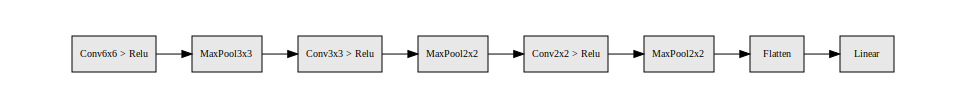

In [41]:

#--- Visualizamos la estructura de nuestra CNN

import hiddenlayer as hl

hl.build_graph(model, torch.zeros([32,1,28,28]))

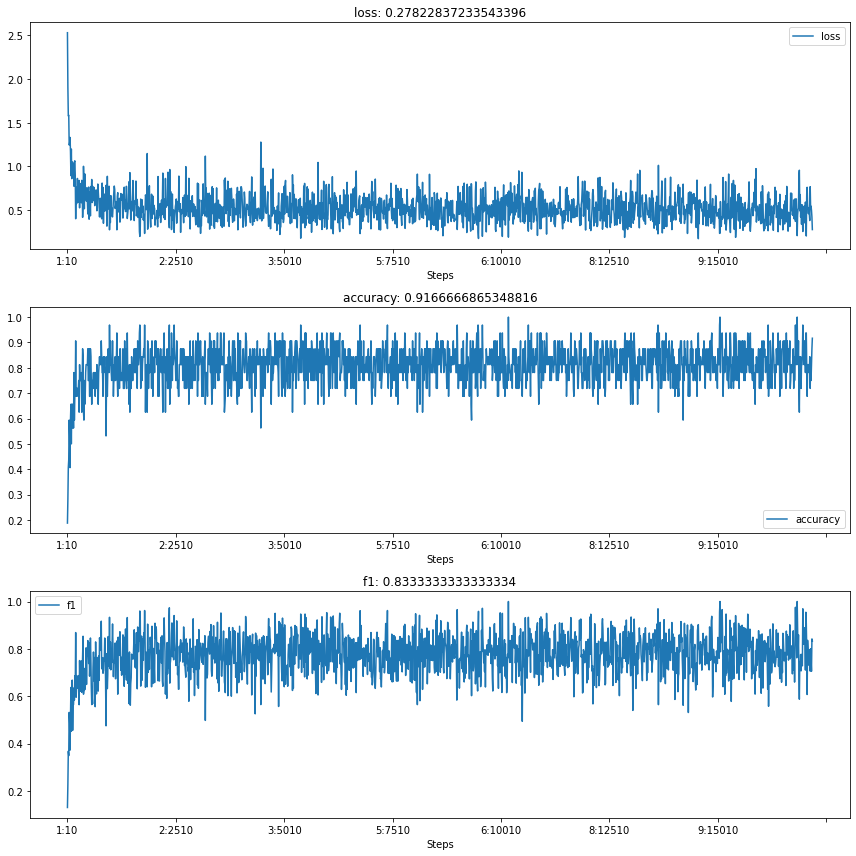

In [43]:
#-- Cargamos el modelo en la GPU
from sklearn.metrics import f1_score
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

n_epoch = 10

history2 = hl.History()
canvas2 = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):

    #-- Cargamos los datos en la GPU
    X_train_batch, Y_train_batch = X_train_batch.to(device), Y_train_batch.to(device)

    model.train()
    Xtr = X_train_batch.unsqueeze(1)
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)

    #-- Calculamos el f1 en la cpu
    f1 = f1_score(Y_train_batch.cpu(),Y_pred.cpu(), average='macro')

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        history2.log((epoch+1, iter),f1=f1 ,loss=loss, accuracy=acc)
        with canvas2:
          canvas2.draw_plot(history2["loss"])
          canvas2.draw_plot(history2["accuracy"])
          canvas2.draw_plot(history2["f1"])

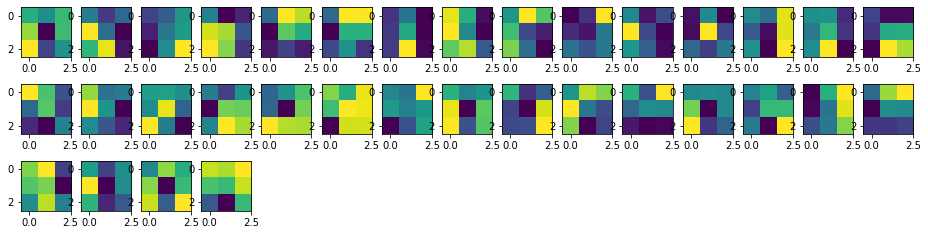

In [76]:
#-- Visualizando los mapas de características de la primera capa convolucional
kernels = list(model.children())[4].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0

for i in range(kernels.size(0)):
    plt.subplot(3,15,k+1)
    plt.imshow(kernels[i][0].cpu().squeeze())
    k += 1
plt.show()

In [45]:

from sklearn.metrics import confusion_matrix

def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")


Loss:0.41, F1:0.85, Acc:0.85


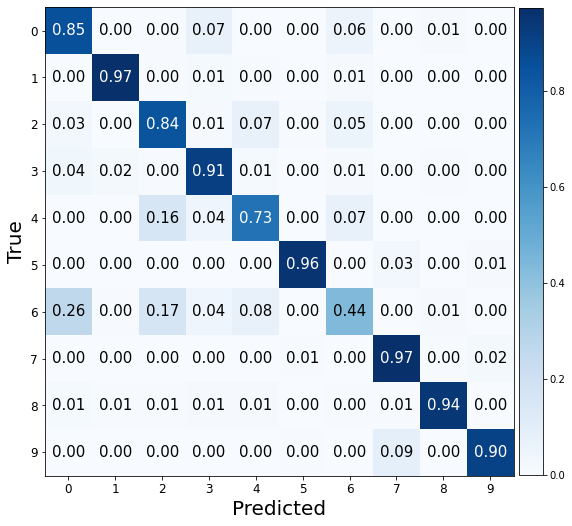

In [59]:

#-- Validamos el modelo

X_test, Y_test = X_test.to(device), Y_test.to(device)
model.eval()
Xvl = X_test.unsqueeze(1)
Y_pred = model(Xvl)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test.cpu(), Y_pred.cpu(), average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)
CM(Y_test.cpu(), Y_pred.cpu(), 10)

print( 'Loss:{:.2f}, F1:{:.2f}, Acc:{:.2f}'.format(loss.item(), f1, acc ) )

#El modelo que entrene fue el siguiente:
### 3 capas de convolucion, las cuales estan distribuidas  de la siguiente forma:
### La primera la cual pasa de 1 a 20  y con un kernel 6,stride 1 y padding 1.Luego, sigue la capa ReLu y un MaxPool2d con un kernel 3 y con un Dropout que desactiva el 15 % de las neuronas. La segunda capa llega de 20 a 34 con kernel de 3, stride 1 y padding 1.Luego, sigue la capa ReLu y un MaxPool2d con un kernel 3 y con un Dropout que desactiva el 12 % de las neuronas.Por ultimo, la ultima capa que pasa de 35 a 30 con kernel de 2, stride 1 y padding 3. Luego una Relu, MaxPoold con kernel de 2 y un Dropout que desactiva el 20%. Al finalizar, una capa que nos aplana las caracteristcas y nuestra ultima capa

### Resultados: Usando el data set de testeo se obtienen los datos de: Loss:0.41, F1:0.85, Acc:0.85. Los cuales son buenos pero no son los mejores para nuestras clasificacion. Tambien, se puede observar la matriz de confusion donde encontramos que la clase mas dificil de clasificar es la numero 6. Ya que se confunde mucho con la clase 0 y con otras clases. Estos resultados(que no son los mejores) son producto a que no se ajustaron los parametros de nuestro modelo a obtener la mayor optimizacion posible sino que a probar la funcionalidad de las capas en convolucion.

